# Analysis of Daily Mail Headlines
Author: Adil Khan

This notebook analyses the headlines listed in the Daily Mail online archives. 

The goal is to create a dash web app that will:

1. Track sentiment. The user will be able to interactively select which genre(s) to analyse and adjust the frenquency of analysis.
2. Generate word clouds for each genre. The user will be able to adjust the genre(s), the time period and the number of words in the word cloud.


Further avenues for analysis:

1. Use fbprophet to detect trends and make predictions.
2. Do changepoints occur at key political/social momemnts, e.g. Brexit, US election?
3. Parralelize fbprophet using https://github.com/PierreGe/fbprophet-headless)
4. More wordcloud masks options

In [21]:
import pandas as pd
import numpy as np
import datetime    
from matplotlib import pyplot as plt
import plotly.graph_objs as go
import nltk
import wordcloud
from PIL import Image, ImageFont, ImageDraw
import base64

## Load Data

In [2]:
#Choose range from 2013 to 2018 to analyse
fileList = [('DailyMail%s.csv' %str(i)) for i in range(2013,2018+1)]

#Create a list of dataframes
dfList = [pd.read_csv(fileList[i],
                      encoding='latin1',
                      names = ['YearID', 'Date', 'Genre', 'Sentiment', 'Title'])
          for i in range(len(fileList))]

#WARNING: CHANGE 'YearID' datatype to int

#Concatenate
df=pd.concat(dfList)

#Drop any null rows because there are plenty of records
df=df.dropna()

#Format datatype
df['Sentiment']=pd.to_numeric(df['Sentiment'])
df['YearID']=df['YearID'].astype(int)

/Users/Adil/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



## Handle multiple date formats


In [5]:
df.sample(10)

,YearID,Date,Genre,Sentiment,Title
227377,891,2015-06-15,wires,0.0000,Sweden's Princess Madeleine gives birth to son
123843,369,2016-03-24,sport,0.0000,Robert Griffin III signs for Cleveland Browns ...
161946,290,11/04/17,wires,0.4588,New York $40mn attraction puts world in miniature
423147,1338,29/09/17,wires,0.4118,European shares score strong month but Catalon...
372323,611,2016-08-31,wires,0.3612,"Oldest fossils found in Greenland, from time E..."
48052,193,2015-02-06,wires,-0.3182,Lack of ice hampers efforts to net homely inva...
34234,749,22/01/18,news,-0.8966,Flu've been framed! Video pranksters pretend t...
326092,1083,27/07/17,wires,-0.6249,"In the ruins of Mosul, a hunt for the missing"
266392,212,2015-07-17,sciencetech,-0.4404,Would you make the cut? Controversial Mars One...
22674,1180,16/01/17,wires,-0.3818,"Uganda confirms Avian flu in wild terns, domes..."


Two data formats are present: 'Y/%m/%d'  &   '%d/%m/%y'

Invalid dates are present, e.g. 30-02-2017




In [6]:
#Test to see if each date can be converted. If neither format works, append index to invalid.

invalid=[]

for i in range(len(df['Date'])):
    try:
        pd.to_datetime(df['Date'].iloc[i],format='%Y-%m-%d')
    except ValueError:
        try:
            pd.to_datetime(df['Date'].iloc[i],format='%d/%m/%y')
        except ValueError:
            invalid.append(i)
            
#Take indices that are not in invalid

valid = [i for i in range(len(df.index)) if i not in invalid]
df=df.iloc[valid]

#Convert to datetime and set to index

df['ds']=pd.to_datetime(df['Date'])
df=df.set_index(df.ds)
df.index.name='dt'

#Draw a sample
df.sample(10)

,YearID,Date,Genre,Sentiment,Title,ds
dt,,,,,,
2014-02-11,22392,2014-02-11,money,-0.5994,Supermarkets battle to attract customers as th...,2014-02-11
2018-02-02,516,02/02/18,wires,0.0000,Republican memo: Steele dossier 'essential' pa...,2018-02-02
2016-12-08,1746,2016-12-08,wires,-0.6486,11 miners confirmed dead in China mine blast,2016-12-08
2016-05-13,1107,2016-05-13,wires,0.0000,Pittsburgh mayor wants cop killer's profile of...,2016-05-13
2017-03-08,549,03/08/17,home,0.2714,Look who's rockin back into town.... From Blon...,2017-03-08
2014-11-05,268632,2014-11-05,wires,0.4019,XPO Logistics gets boost from tight U.S. trans...,2014-11-05
2016-02-29,1508,2016-02-29,tvshowbiz,-0.6508,'I don't care much for cheaters!' My Kitchen R...,2016-02-29
2017-09-06,1296,09/06/17,wires,0.4939,Thai prosecutors confident of catching Red Bul...,2017-09-06
2013-08-21,418,2013-08-21,news,0.0000,The incredible shrinking houses: The average n...,2013-08-21


## Group by genre and date. Calculate the mean sentiment in each group

In [7]:
#Group by genre and date
groups = df.groupby(['Genre','ds'])

#Create a list of genres
GenreList=list(set([name[0] for name,group in groups]))

#Create indices
genres = [name[0] for name, group in groups]
dates = [name[1] for name, group in groups]

#Calculate mean sentiment for each certain genre and for each date
meanSent = [group.Sentiment.mean() for name, group in groups]

#Create a new dataframe    
df2 = pd.DataFrame({'Daily_Sentiment':meanSent},index= [genres,dates])
df2.index.names = ['Genre','Date']
df2.head(20)

Daily_Sentiment
Genre     Date                       
auhome    2014-07-04           0.2714
          2014-07-09           0.6946
          2014-07-28           0.4389
          2014-08-12           0.7158
          2014-08-25          -0.2263
          2014-09-01           0.2960
          2014-10-13           0.8573
          2014-11-03          -0.5106
          2014-11-20           0.0000
          2014-12-10           0.8834
          2014-12-13           0.7263
          2014-12-16           0.7351
          2015-01-07           0.5940
          2015-04-29          -0.3612
          2015-05-03          -0.7003
          2016-02-08          -0.4493
aushowbiz 2014-07-06          -0.6621
          2014-07-07          -0.7506
          2014-08-04           0.6588
          2014-08-06           0.0772

## Order genres by data quality

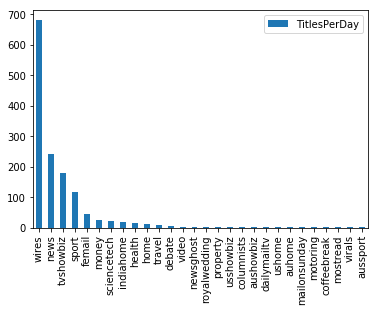

In [73]:
#Data quality is equivalent to the total number of articles divided by 
# the number of days the genre appears.

titlesPerDay = [ len(df[df.Genre==genre]) / len(df2.loc[genre]) for genre in GenreList]
quality = pd.DataFrame({'TitlesPerDay':titlesPerDay},index = GenreList).sort_values(by='TitlesPerDay',ascending=False)
quality.plot.bar()

## Most comon words

In [58]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords+=[' ','','-','the','could', "'i", '(and', 'new','says', '\x89ûò', '1:']

#Function takes a list of titles and returns top n words

titles = list(df[df.Genre=='sport'].iloc[:].Title)

def topwords(titles, n=10):

    #join titles together
    text = ' '.join(list(titles))

    #Split them into a list of words
    text = text.split(' ')

    #Filter stopwords
    text = [word.lower() for word in text if word.lower() not in stopwords]

    #Frequency distribution
    return nltk.FreqDist(text).most_common(n)

## Wordclouds

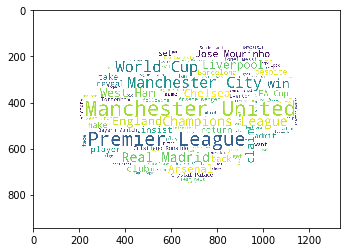

[('manchester', 24353),
 ('league', 24251),
 ('united', 18118),
 ('cup', 17355),
 ('england', 16769),
 ('world', 14098),
 ('city', 13342),
 ('premier', 13206),
 ('boss', 12880),
 ('chelsea', 11972)]

In [59]:
titles =  df[df.Genre=='sport'].iloc[:].Title
text = ' '.join(list(titles))

#Generate a wordcloud object

wc=wordcloud.WordCloud(stopwords = stopwords,
                       background_color='white',
                       max_words=100,
                       mask=np.array(Image.open('cloud.png')))

#Provide space separated list of words to wc object
wc.generate(text)

#Print word cloud

plt.imshow(wc)
plt.show()

#Print frequency distribution

topwords(titles,10)

## Build web app using dash

In [70]:
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
    
options = [{'label': i, 'value': i} for i in quality.index]

image_filename = '/Users/Adil/Documents/Data Science/NLTK/wc.png'


app = dash.Dash()

app.layout = html.Div([
    
    html.H1(
        'Does the Daily Mail have feelings?'
    ),
    
    html.Div(
        'Sentiment analysis of a headline provides an emotional score from -1 to +1,\
        where -1 indicates a negative response and +1 indicates a positive response.'
    ),
    
    dcc.Dropdown(
        id='my-dropdown1',
        options=options,
        multi=True,
        placeholder='Start select one or more genres.'
    ),
    
    dcc.RadioItems(
        id='my-radio', 
        options=[
            {'label':'Daily', 'value':'D'},
            {'label':'Weekly', 'value':'W'},
            {'label':'Bi-monthly', 'value':'SM'},
            {'label':'Monthly', 'value':'M'},
            {'label':'Quarterly', 'value':'Q'},
            {'label':'Yearly', 'value':'A'}
                   ],
        value='Q'
        ),
    html.Div(
        id='my-graph1'),
    
    html.H3(
        'Word Cloud Generator'
      ),
    
    dcc.Dropdown(
        id='my-dropdown2',
        options= [{'label': str(i), 'value': i} for i in range(2013,2019)],
        multi=True
    ),
    
    dcc.Input(
        id='my-number', 
        type = 'number', 
    ),
        
    html.Img(
        id='word-cloud'
    )

])

@app.callback(
    Output(component_id='my-graph1', component_property='children'),
    [Input(component_id='my-dropdown1', component_property='value'),
    Input(component_id='my-radio', component_property='value')]
)


def update_graph(selected_dropdown_value, frequency):

    try:
        data=[go.Scatter(x=df2.loc[i].resample(frequency).mean().index,
                         y=df2.loc[i].resample(frequency).mean().Daily_Sentiment,
                         name=str(i)) for i in selected_dropdown_value]
    
        return     dcc.Graph(id='outgraph1',
            figure=go.Figure(data=data,
            layout=go.Layout(showlegend=True)
                     ))
    
    except TypeError:
        return None #dcc.Graph(id='outgraph1')

@app.callback(
    Output(component_id='word-cloud', component_property='src'),
    [Input(component_id='my-dropdown1', component_property='value'),
    Input(component_id='my-dropdown2', component_property='value'),
    Input(component_id='my-number', component_property='value')]
)


def update_word_cloud(genre,year,number):
    
    wc=wordcloud.WordCloud(stopwords = stopwords,
                       background_color='white',
                       max_words=number,
                       mask=np.array(Image.open('cloud.png')))
    
    try:
        titles = list(df[(df.ds.dt.year.isin(year)) & (df.Genre.isin(genre))].Title)
        join = ' '.join(titles)      
        wc.generate(join)
        wc.to_file(image_filename)
        encoded_image = base64.b64encode(open(image_filename, 'rb').read())
        return 'data:image/png;base64,{}'.format(encoded_image.decode())

    except TypeError:
        return None




if __name__ == '__main__':
    app.run_server(port = 8052)

INFO:werkzeug: * Running on http://127.0.0.1:8052/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [27/Jun/2018 12:17:07] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2018 12:17:09] "GET /_dash-layout HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2018 12:17:09] "GET /_dash-dependencies HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2018 12:17:10] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2018 12:17:10] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2018 12:17:16] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2018 12:17:18] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2018 12:17:18] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2018 12:17:18] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [27/Jun/2018 12:17:20] "POST /_dash-update-component HTTP/1.1" 2